In [1]:
def infusion(start_treatment, drug_dose, n_cycles, cycle_time, baseline_drug_dose, drug_deltas):
    # create parameters for step function 
    A1infusion = [np.array([21, 127/6]),  np.array([28, 169/6])]
    A2infusion = [np.array([0, 1/6]), np.array([1, 7/6])]
    A3infusion = [np.array([0, 1/6]), np.array([1, 7/6])]
    infusion_idx = np.concatenate([15*np.ones(n_cycles*len(A1infusion)), 16*np.ones(n_cycles*len(A2infusion)), 
                                   17*np.ones(n_cycles*len(A3infusion))]).astype(int)

    infusion_vals = np.concatenate([(drug_dose[0]/baseline_drug_dose[0])*drug_deltas[0]/(A1infusion[0][1] - A1infusion[0][0])*np.ones(n_cycles*len(A1infusion)),
                                    (drug_dose[1]/baseline_drug_dose[1])*drug_deltas[1]/(A2infusion[0][1] - A2infusion[0][0])*np.ones(n_cycles*len(A2infusion)),
                                    (drug_dose[2]/baseline_drug_dose[2])*drug_deltas[2]/(A3infusion[0][1] - A3infusion[0][0])*np.ones(n_cycles*len(A3infusion))])

    infusion_intervals = np.concatenate([[start_treatment+i*cycle_time+j for i in range(n_cycles) for j in A1infusion],
                                         [start_treatment+i*cycle_time+j for i in range(n_cycles) for j in A2infusion],
                                         [start_treatment+i*cycle_time+j for i in range(n_cycles) for j in A3infusion]])
    
    return infusion_idx, infusion_vals, infusion_intervals

In [2]:
def optimal_dose_loss_func(drug_dose, T, cluster, ICs, desired_C, reg): # doses here is x in fun(x, *args) in scipy.optimize.minimize
    # some global parameters
    clusters=3 #number of clusters

    cycle_time=35
    n_cycles=2
    start_treatment = 7
    nvar=OS_MAP_Functions().nvar # number of variables
    t = np.linspace(0, T, 10*T+1)

    # pre-defined parameters for treatment deltas, typical drug_dose
    drug_deltas=[1.4466, 8.3178, 39.9253]
    baseline_drug_dose=[381.90955, 1.19347, 1.90955]
    
    
    infusion_idx, infusion_vals, infusion_intervals = infusion(start_treatment, drug_dose, n_cycles, cycle_time, 
                                                               baseline_drug_dose, drug_deltas)
    r= step_vector(nvar, indices=infusion_idx, intervals=infusion_intervals, values=infusion_vals)
    
    betas = [2.4780, 1.8328, 0.1467]
    K_C = 0.9
    K_immune = 0.6
    a = 16
    alphaNCA = 0.8
    deltaCTcA3_scale = 1
    
    
    QSP0=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
    qspcore=OS_MAP_Functions(parameters=QSP0.par)
    deltaCTcA3 = QSP0.par[37]*deltaCTcA3_scale
    QSP_=QSP.from_data(([drug_deltas, betas, K_C, K_immune, a, alphaNCA, deltaCTcA3, baseline_drug_dose, 
                         clustercells[cluster]]), qspcore=qspcore)

    C_after_chemo = []
    
    for IC in ICs:
        u, _ = QSP_.solve_ode(t, IC, 'given', inhomogeneity=r, jumps=True)
        # Add last 3 equations scaling value
        scale = np.concatenate([clustercells[cluster], np.array(baseline_drug_dose)/np.array(drug_deltas)])
        u = scale*u
        C_after_chemo.append(u[10*T][8])
        
    print(np.sum((np.array(C_after_chemo) - desired_C)**2))
    return np.sum((np.array(C_after_chemo) - desired_C)**2) + reg*np.sum(np.abs(drug_dose))


In [3]:
def validate_optimization(optimal_drug_dose, T, cluster, IC, desired_C): # doses here is x in fun(x, *args) in scipy.optimize.minimize
    # some global parameters
    clusters=3 #number of clusters

    cycle_time=35
    n_cycles=2
    start_treatment = 7
    nvar=OS_MAP_Functions().nvar # number of variables
    t = np.linspace(0, T, 10*T+1)

    # pre-defined parameters for treatment deltas, typical drug_dose
    drug_deltas=[1.4466, 8.3178, 39.9253]
    baseline_drug_dose=[381.90955, 1.19347, 1.90955]
    
    
    infusion_idx, infusion_vals, infusion_intervals = infusion(start_treatment, optimal_drug_dose, n_cycles, cycle_time, 
                                                               baseline_drug_dose, drug_deltas)
    r= step_vector(nvar, indices=infusion_idx, intervals=infusion_intervals, values=infusion_vals)
    
    betas = [2.4780, 1.8328, 0.1467]
    K_C = 0.9
    K_immune = 0.6
    a = 16
    alphaNCA = 0.8
    deltaCTcA3_scale = 1
    
    
    QSP0=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
    qspcore=OS_MAP_Functions(parameters=QSP0.par)
    deltaCTcA3 = QSP0.par[37]*deltaCTcA3_scale
    QSP_=QSP.from_data(([drug_deltas, betas, K_C, K_immune, a, alphaNCA, deltaCTcA3, baseline_drug_dose, 
                         clustercells[cluster]]), qspcore=qspcore)

    u, _ = QSP_.solve_ode(t, IC, 'given', inhomogeneity=r, jumps=True)
    # Add last 3 equations scaling value
    scale = np.concatenate([clustercells[cluster], np.array(baseline_drug_dose)/np.array(drug_deltas)])
    u = scale*u
    
    print('Cancer after chemo: ', u[10*T][8])
    print('Error: ', (u[10*T][8] - desired_C)**2)


In [4]:
def plot_optimal_dose(drug_doses, T, IC, title):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import seaborn as sns
    
    # some global parameters
    clusters=3 #number of clusters

    cycle_time=35
    n_cycles=2
    start_treatment = 7
    nvar=OS_MAP_Functions().nvar # number of variables
    t = np.linspace(0, T, 10*T+1)

    # pre-defined parameters for treatment deltas, typical drug_dose
    drug_deltas=[1.4466, 8.3178, 39.9253]
    baseline_drug_dose=[381.90955, 1.19347, 1.90955]
    
    betas = [2.4780, 1.8328, 0.1467]
    K_C = 0.9
    K_immune = 0.6
    a = 16
    alphaNCA = 0.8
    deltaCTcA3_scale = 1
    
    dynamic_all = []
    
    for cluster in range(3):
        print(cluster)
        infusion_idx, infusion_vals, infusion_intervals = infusion(start_treatment, drug_doses[cluster], n_cycles, cycle_time, 
                                                                   baseline_drug_dose, drug_deltas)
        r= step_vector(nvar, indices=infusion_idx, intervals=infusion_intervals, values=infusion_vals)
        
        QSP0=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
        qspcore=OS_MAP_Functions(parameters=QSP0.par)
        deltaCTcA3 = QSP0.par[37]*deltaCTcA3_scale
        print(QSP0.par[37], deltaCTcA3)
        QSP_=QSP.from_data(([drug_deltas, betas, K_C, K_immune, a, alphaNCA, deltaCTcA3, baseline_drug_dose, 
                             clustercells[cluster]]), qspcore=qspcore)

        dynamic_df = pd.DataFrame(columns=['time (days)', 'Cluster']+QSP_.variable_names())
        t = np.linspace(0, T, 10*T+1)
        dynamic_df['time (days)'] = t
        dynamic_df['Cluster'] = ['Cluster '+str(cluster+1)]*len(dynamic_df['time (days)'])
        
        u, _ = QSP_.solve_ode(t, IC[cluster], 'given', inhomogeneity=r, jumps=True)
        # Add last 3 equations scaling value
        scale = np.concatenate([clustercells[cluster], np.array(baseline_drug_dose)/np.array(drug_deltas)])
        u = scale*u
        
        dynamic_df[QSP_.variable_names()] = u
        dynamic_df['Total cells'] = dynamic_df[dynamic_df.columns[2:-7]].sum(axis=1)
        dynamic_all.append(dynamic_df)
        
    dynamic_all_df = pd.concat(dynamic_all, axis=0)
    fig, ax = plt.subplots(figsize=(6,4))
    palette={'Cluster 1':'#3F9B0B', 'Cluster 2':'#FF796C', 'Cluster 3':'#0343DF'}
    plt.rcParams.update({'font.size': 13})
    
    sns.lineplot(data=dynamic_all_df, x='time (days)', y='Cancer cells  ($C$)', hue='Cluster', palette=palette, ax=ax)#, legend=False)
    ax.margins(x=0)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.legend_.set_title(None)
    ax.yaxis.major.formatter._useMathText = True
    
    fig.savefig('Figures/Optimal_dose_'+title+'.pdf', bbox_inches='tight')
    fig.savefig('Figures/Optimal_dose_'+title+'.eps', bbox_inches='tight')
    fig.savefig('Figures/Optimal_dose_'+title+'.png', bbox_inches='tight')
    
    plt.show()

In [5]:
from qspmodel import *
from chemo_qspmodel import *
import pandas as pd
import csv
import os
import scipy as sp

clustercells = pd.read_csv('input/TARGET_steady_states.csv')
clustercells.drop('Unnamed: 0', axis=1, inplace=True)
clustercells = clustercells.to_numpy()

meanvals = pd.read_csv('input/TARGET_avg_by_cluster.csv')
meanvals.drop('Unnamed: 0', axis=1, inplace=True)
meanvals = meanvals.to_numpy()

### Optimize for large tumors (steady states) in each cluster, desired C = 2.916e+9 cells (5cm per dimension)

In [6]:
# Initial conditions with steady state tumors
large_IC = np.ones((3, 14))
large_IC = np.concatenate([large_IC, np.zeros((3,3))], axis=1)
large_IC

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0.]])

##### Cluster 1

In [7]:
from scipy.optimize import minimize
import time

drug_dose_0 = [381.90955, 1.19347, 1.90955]
bounds = ((0,636.5159), (0,1.4322), (0,2.3869)) # 20,000mg MTX, 45mg DOX/day, 75mg CDDP/day

start_time = time.time()
res1l = minimize(fun = optimal_dose_loss_func, x0 = drug_dose_0, args = (80, 0, [large_IC[0]], 2.916e+9, 0.05), bounds = bounds)
print('Run time: ', time.time() - start_time)

C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


2.2293814034435757e+17
2.2293814035368982e+17
2.2293814933854723e+17
2.2293814063147235e+17
1.1057874161946242e+20
1.1057874073360074e+20
1.1057874007807279e+20
1.10578741593475e+20
3.916143069912582e+16
3.91614306916074e+16
3.916142497149422e+16
3.9161430550088024e+16
1.2459975714855542e+16
1.2459975717959504e+16
1.2459978439763146e+16
1.2459975792112562e+16
449640303968325.9
449640304658759.06
449640840329413.4
449640318285300.06
660909499341.8342
660909524032.1122
660930480616.4712
660910062486.6711
18868530062.917255
18868525849.061592
18864982026.689827
18868434592.81212
76321.31367621972
76312.62563666537
69353.2523366388
76129.53111005007
6.975993201285746
6.891258373509345
105.52361045783618
5.25913591722292
19.73112599285946
19.59421325311473
71.75895106514508
16.762135046821868
8.018089252422214
7.932455736478005
101.63623951957925
6.176185502587032
7.088451240211725
7.009155458240457
105.08440727935545
5.358523221484802
6.985787424730233
6.909475923157743
105.48238064096972


In [8]:
res1l.x

array([286.21084212,   0.88829983,   1.43028964])

In [9]:
validate_optimization(res1l.x, 80, 0, large_IC[0], 2.916e+9)

C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after chemo:  2916000002.640478
Error:  6.972124776952114


##### Cluster 2

In [11]:
from scipy.optimize import minimize
import time

drug_dose_0 = [381.90955, 1.19347, 1.90955]
bounds = ((0,636.5159), (0,1.4322), (0,2.3869)) # 20,000mg MTX, 45mg DOX/day, 75mg CDDP/day

start_time = time.time()
res2l = minimize(fun = optimal_dose_loss_func, x0 = drug_dose_0, args = (80, 1, [large_IC[1]], 2.916e+9, 0.05), bounds = bounds)
print('Run time: ', time.time() - start_time)

9.776384985228586e+16
9.776384985892738e+16
9.776385687547534e+16
9.776385007147891e+16
1.721981328577868e+20
1.7219813151911356e+20
1.7219813042516617e+20
1.7219813281685956e+20
2.226368486570796e+17
2.2263684863699046e+17
2.2263683200991827e+17
2.226368482280719e+17
791924206976904.2
791924207783612.4
791924964734823.9
791924228744175.2
326238206405292.1
326238205873580.7
326237706745109.75
326238192120155.6
33798451855121.066
33798452019044.508
33798610531369.0
33798456384965.83
49413543778747.85
49413543979755.53
49413736600952.016
49413549311621.23
28164565955901.496
28164566108830.055
28164710851512.383
28164570092564.45
66199127050108.81
66199127284914.98
66199350085495.195
66199133456458.51
26762651534833.547
26762651689433.09
26762792788697.203
26762655571546.453
14796811647355.766
14796811759218.21
14796916759444.455
14796814645128.613
12545442951913.041
12545443054799.62
12545540276634.27
12545445747361.717
584897368487981.5
584897367794231.0
584896697122957.8
58489734936437

In [12]:
res2l.x

array([322.51117413,   1.00858989,   1.61264414])

In [13]:
validate_optimization(res2l.x, 80, 1, large_IC[1], 2.916e+9)

Cancer after chemo:  2916000000.632305
Error:  0.3998097967269132


##### Cluster 3

In [15]:
from scipy.optimize import minimize
import time

drug_dose_0 = [381.90955, 1.19347, 1.90955]
bounds = ((0,636.5159), (0,1.4322), (0,2.3869)) # 20,000mg MTX, 45mg DOX/day, 75mg CDDP/day

start_time = time.time()
res3l = minimize(fun = optimal_dose_loss_func, x0 = drug_dose_0, args = (80, 2, [large_IC[2]], 2.916e+9, 0.05), bounds = bounds)
print('Run time: ', time.time() - start_time)

1.0877084813920598e+18
1.0877084814095695e+18
1.087708499504309e+18
1.087708481956158e+18
1.0984050316926866e+20
1.0984050220943793e+20
1.0984050138310446e+20
1.0984050313925378e+20
1.7195688458861075e+17
1.719568846023904e+17
1.7195689648885078e+17
1.7195688489903507e+17
1.0984050316926866e+20
1.0984050220943793e+20
1.0984050138310446e+20
1.0984050313925378e+20
6.175801320161406e+16
6.175801318585386e+16
6.175800291810841e+16
6.175801296961609e+16
1.1426795133127148e+16
1.1426795137616666e+16
1.1426798866568916e+16
1.1426795225526472e+16
4320249002821792.5
4320248999322413.0
4320246514014138.5
4320248943941132.5
5178439703902.636
5178439818619.354
5178522590080.645
5178441683063.5
337451727024.79297
337451756578.2156
337472917444.09827
337452232938.83716
37805917677.32653
37805907834.33235
37798822215.85921
37805748038.37235
20592.00134018625
20584.97981785001
15688.943704249641
20467.32641560078
57.57020834923969
57.185946773648766
113.57106091115406
51.15164212568288
35.780095302944

5.2892461098963395e-05
0.00033024851313712134
332.5763246280985
0.18318234445564485
5.1398097866695025e-05
0.0003187899746990297
332.57482893078213
0.18328644278517459
5.528401038645825e-05
0.0003006158115113067
332.57329845328877
0.183645911180065
4.748276319332945e-05
0.0003163936091823416
332.5958211763466
0.1831529573394164
0.5886748512805298
0.5507099335429757
305.4551544130411
0.11003459584026132
0.02661273394755881
0.019259523833170533
326.9192966283881
0.07418871832578589
0.0016096244153231964
0.0002271324856337742
331.396796238005
0.15627069086099254
0.0002184356219459005
0.00011107167756563285
332.3413153223612
0.17707923689249583
8.304376046908146e-05
0.0002682989363620436
332.5382201788491
0.1824357460727697
5.379096387514437e-05
0.00030305137988762
332.5774203154763
0.18278907913759213
6.045539430488134e-05
0.00031262206903193146
332.58496843312264
0.18337300978964777
6.0033471754650236e-05
0.0003203584346920252
332.5807421723666
0.18311989965150133
5.608818264590809e-05
0

In [16]:
res3l.x

array([196.56202332,   0.61399786,   0.98288681])

In [17]:
validate_optimization(res3l.x, 80, 2, large_IC[2], 2.916e+9)

Cancer after chemo:  2916000000.006891
Error:  4.748276319332945e-05


##### Plot optimal dose of large tumors

In [9]:
# res1l = [286.21084212,   0.88829983,   1.43028964]
# res2l = [322.51117413,   1.00858989,   1.61264414]
# res3l = [196.56202332,   0.61399786,   0.98288681]
# large_drug_doses = [res1l, res2l, res3l]

In [30]:
large_drug_doses = [res1l.x, res2l.x, res3l.x]

0
0.012269443384292386 0.012269443384292386


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1
0.009657389749427571 0.009657389749427571
2
0.008401675631568845 0.008401675631568845


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


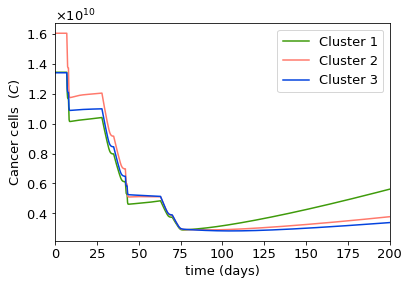

In [12]:
plot_optimal_dose(large_drug_doses, 200, large_IC, 'large')

### Optimize for small tumors in each cluster, desired C = 1.36e+8 (1.8cm per dimension)

In [18]:
# Initial conditions with small tumors
small_IC=pd.read_csv('input/TARGET_nondimensional_initial_conditions.csv')
small_IC.drop('Unnamed: 0', axis=1, inplace=True)
small_IC = small_IC.to_numpy()
# Add 0 as initial drug concentrations to IC
small_IC = np.concatenate([small_IC, np.zeros((3,3))], axis=1)
small_IC

array([[2.36704151e+00, 1.00548860e+00, 1.88661156e-02, 7.93731766e-01,
        7.63946774e-01, 8.27810101e-01, 1.12204553e+00, 0.00000000e+00,
        2.01212968e-02, 1.59566607e-01, 2.39369964e+00, 1.10363881e+00,
        1.80579364e+00, 1.05943821e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [9.87532470e-01, 1.20294276e+00, 6.14106164e-01, 3.17899812e-01,
        2.69138566e+00, 1.82096094e+00, 7.26612875e-01, 0.00000000e+00,
        1.91311656e-02, 3.99676182e-01, 3.53394278e+00, 1.14354090e+00,
        1.43715069e+00, 1.11123637e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [8.65774071e-01, 1.10352852e+00, 5.71933607e-01, 3.39615677e-01,
        4.83925986e-01, 0.00000000e+00, 1.64261578e+00, 0.00000000e+00,
        1.43906276e-02, 8.38059744e-04, 2.76466391e-01, 1.02991955e+00,
        1.29642029e+00, 1.28390849e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

##### Cluster 1

In [19]:
from scipy.optimize import minimize
import time

drug_dose_0 = [381.90955, 1.19347, 1.90955]
bounds = ((0,636.5159), (0,1.4322), (0,2.3869)) # 20,000mg MTX, 45mg DOX/day, 75mg CDDP/day

start_time = time.time()
res1s = minimize(fun = optimal_dose_loss_func, x0 = drug_dose_0, args = (80, 0, [small_IC[0]], 1.36e+8, 0.05), bounds = bounds)
print('Run time: ', time.time() - start_time)

C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


3551866883065073.0
3551866883105839.0
3551866925036883.5
3551866884344510.0
2.7313300397107142e+17
2.7313300095246173e+17
2.731329975754138e+17
2.7313300386281293e+17
1119745398514981.9
1119745398567126.8
1119745439401590.8
1119745399610929.1
238368905802368.62
238368905737814.16
238368870176708.75
238368904984177.0
168610300522353.72
168610300551526.06
168610321020406.66
168610300978107.75
2.7313300397107142e+17
2.7313300095246173e+17
2.731329975754138e+17
2.7313300386281293e+17
249528290429319.06
249528290365019.25
249528253810762.5
249528289585154.53
943566843801.8599
943566846657.4081
943568615427.691
943566880857.9838
269418247694.0575
269418246114.66763
269417289064.33795
269418227808.03864
7598477538.36275
7598477277.01425
7598317031.296073
7598474221.1216135
22376820723.013218
22376821166.07651
22377095538.581654
22376826433.88652
4908399993.633739
4908399785.114357
4908271013.2109585
4908397306.897708
2064484571.713117
2064484707.2195258
2064568170.3845754
2064486318.095465
11

In [20]:
res1s.x

array([156.76598978,   0.49021886,   0.78384939])

In [21]:
validate_optimization(res1s.x, 80, 0, small_IC[0], 1.36e+8)

C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after chemo:  135980722.86649707
Error:  371607876.0898018


##### Cluster 2

In [22]:
from scipy.optimize import minimize
import time

drug_dose_0 = [381.90955, 1.19347, 1.90955]
bounds = ((0,636.5159), (0,1.4322), (0,2.3869)) # 20,000mg MTX, 45mg DOX/day, 75mg CDDP/day

start_time = time.time()
res2s = minimize(fun = optimal_dose_loss_func, x0 = drug_dose_0, args = (80, 1, [small_IC[1]], 1.36e+8, 0.05), bounds = bounds)
print('Run time: ', time.time() - start_time)

4716057135763520.0
4716057135805830.0
4716057183372323.0
4716057137304602.0
2.7120255814837002e+17
2.712025549975646e+17
2.7120255111030973e+17
2.7120255802966675e+17
1924217496521718.0
1924217496567131.2
1924217548647347.2
1924217497904377.0
11327752281238.744
11327752267930.898
11327744752702.988
11327752122682.44
263402953743835.22
263402953784021.03
263402982856184.84
263402954406255.4
22697465.43490833
22697483.101671822
22707777.575273953
22697687.757659674
454.98555943466016
455.06006214462343
502.3235090700605
455.97834938765544
0.023257414588010228
0.0238149112462418
1.5244518420498219
0.03089589424096406
0.11178686665264426
0.11059330109788235
0.5592525668834947
0.09679465517003027
0.001334995310745768
0.0014706071424122058
1.2515152899142103
0.0035766458467145767
0.1675319787563332
0.1660649688553839
0.4527948394441097
0.1490009293286798
0.002167394159698688
0.0020051137064394098
1.0726234858067238
0.0005414490264143978
0.00032837511015770815
0.00039699961850292453
1.2106986

1.50795731457265e-07
1.166446119859729
0.00044524330944373247
334133308583691.7
334133308566715.7
334133250594606.56
334133307600495.9
9670646293212.479
9670646270984.062
9670653135630.135
9670646509685.533
0.01701369087585647
0.01748834701119506
1.4704470235819969
0.023628177400102146
0.0006021344286546437
0.0006920920517963225
1.2249056808708056
0.0022857408335177354
1.1900486826199597e-05
2.7645246647445276e-05
1.1785826604279102
0.0007139242813005708
9.583366136212135e-07
6.707571040820426e-07
1.1690277970297425
0.0004965235777811827
3.8774684165687745e-06
1.4169292970933611e-05
1.1753476555045985
0.0006360757965859776
1.2602873766809353e-07
2.1571327160074816e-06
1.1703882502042982
0.0005256904276826901
1.294573056753734e-06
8.982074612085e-06
1.173679902501945
0.000598623460988712
5.320863749602722e-10
3.0821145315940157e-06
1.171096122362969
0.0005403192570918591
5.320416329723798e-07
6.585476754139563e-06
1.1727075611179325
0.0005773205917245505
1.7234236260321723e-08
3.6797071

In [23]:
res2s.x

array([133.52830013,   0.41333047,   0.66728789])

In [24]:
validate_optimization(res2s.x, 80, 1, small_IC[1], 1.36e+8)

Cancer after chemo:  136000000.00002307
Error:  5.320863749602722e-10


##### Cluster 3

In [25]:
from scipy.optimize import minimize
import time

drug_dose_0 = [381.90955, 1.19347, 1.90955]
bounds = ((0,636.5159), (0,1.4322), (0,2.3869)) # 20,000mg MTX, 45mg DOX/day, 75mg CDDP/day

start_time = time.time()
res3s = minimize(fun = optimal_dose_loss_func, x0 = drug_dose_0, args = (80, 2, [small_IC[2]], 1.36e+8, 0.05), bounds = bounds)
print('Run time: ', time.time() - start_time)

8673604860572156.0
8673604860606708.0
8673604899473085.0
8673604861809784.0
6.7132969076819336e+16
6.71329681509133e+16
6.7132967063460664e+16
6.713296904284596e+16
5920405447107287.0
5920405447169613.0
5920405502644711.0
5920405448535081.0
1002698013153808.4
1002698013298430.8
1002698067800660.2
1002698014228336.5
136173555570994.7
136173555352476.1
136173523959287.42
136173555015946.11
227566591115224.75
227566591231671.12
227566622832345.4
227566591703421.1
136173555570994.7
136173555352476.1
136173523959287.42
136173555015946.11
5117715702061791.0
5117715702109126.0
5117715766150520.0
5117715703496313.0
556559738403426.06
556559738517063.8
556559784583268.3
556559739257860.56
7734700741879.426
7734700772250.608
7734707457524.093
7734700862089.7295
741973056122.4412
741973065887.0533
741975164695.2811
741973093409.6884
4363554.038380937
4363577.501112512
4368721.710571574
4363645.822193976
13114.926095259327
13116.223692443587
13399.709640117451
13120.008233367003
0.6766382155633579

In [26]:
res3s.x

array([41.53255255,  0.09778061,  0.20647202])

In [27]:
validate_optimization(res3s.x, 80, 2, small_IC[2], 1.36e+8)

Cancer after chemo:  136000000.0209526
Error:  0.0004390119563959516


##### Plot optimal dose for small tumors

In [34]:
# res1s = [156.76598978,   0.49021886,   0.78384939]
# res2s = [133.52830013,   0.41333047,   0.66728789]
# res3s = [41.53255255,  0.09778061,  0.20647202]
# small_drug_doses = [res1s, res2s, res3s]

In [28]:
small_drug_doses = [res1s.x, res2s.x, res3s.x]

0
0.012269443384292386 0.012269443384292386


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1
0.009657389749427571 0.009657389749427571
2
0.008401675631568845 0.008401675631568845


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


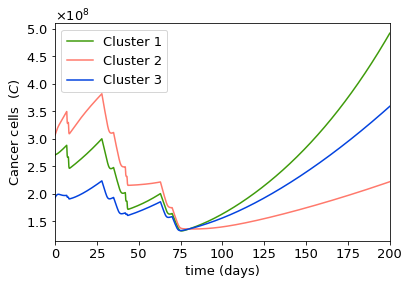

In [32]:
plot_optimal_dose(small_drug_doses, 200, small_IC, 'small')